Ovaj primer ilustruje primenu diskretne Furijeove transformacije u radu radara koji na osnovu 
prikupljenih podataka vizualizuje ciljani objekat (stenu).

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# podaci koje je radar prikupio se nalaze u npz (numpy gzip) arhivi
# npz arhive omogucavaju cuvanje kompresovanih nizova podataka 
data = np.load('podaci/radar_scan.npz')
#type(data)
#data.files

In [14]:
# u arhivi se nalazi tacno jedan niz sa imenom scan
scan = data['scan']

In [37]:
# njegovi elementi su slozenog tipa koji je prilagodjen radarskom domenu
# i predstavljaju merenja radara za svaku poziciju antene radara odredjene azimutom i visinom 
scan.dtype

dtype([('time', '<u8'), ('size', '<u4'), ('position', [('az', '<f4'), ('el', '<f4'), ('region_type', 'u1'), ('region_ID', '<u2')]), ('gain', 'u1'), ('samples', '<i2', (2048,))])

In [55]:
# npr. velicine pojedinacnih merenja 
# 20 mogucih pozicija za pomeraje levo-desno (azimut) i 30 pozicija za pomeraje gore-dole (visina, elevacija)
scan['size'].shape

(30L, 20L)

In [67]:
# uzorci merenja radara se nalaze u polju samples
samples = scan['samples']
#samples.shape

In [68]:
# ukupan broj uzoraka
N = samples.shape[2]
N

2048L

In [64]:
# amplitude signala treba da budu u opsegu od -2.5V do +2.5V
# 14-bitni analogno-digitalni-konverter u radaru daje izlaz izmedju -8192 i 8192
# vrednosti vracamo u pozeljni opseg mnozenjem sa 2.5 / 8192 
v = samples * 2.5 / 8192

# koristimo Haningov prozor
win = np.hanning(N + 1)[:-1]

# primenjujemo Furijeovu transformaciju
V = np.fft.fft(v * win, axis=2)[::-1, :, :N // 2]

In [65]:
# pripremamo podatke za iscrtavanje
r = np.argmax(V, axis=2)
el, az = np.meshgrid(*[np.arange(s) for s in r.shape], indexing='ij')
axis_labels = ['Elevation', 'Azimuth', 'Range']
coords = np.column_stack((el.flat, az.flat, r.flat))

**mpl_toolkits** je kolekcija specificnih funkcija koja nadgradjuje funkcionalnost *matplotlib* biblioteke. 

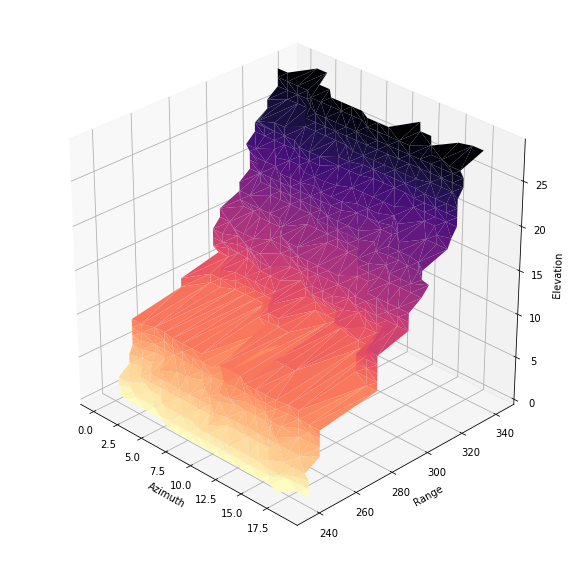

In [66]:
from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial

# postavljaju se 3D ose
figure, axis = plt.subplots(1, 1,
                     figsize=(10, 10),
                     subplot_kw=dict(projection='3d'))

d = spatial.Delaunay(coords[:, :2])
simplexes = coords[d.vertices]
coords = np.roll(coords, shift=-1, axis=1)
axis_labels = np.roll(axis_labels, shift=-1)

axis.plot_trisurf(*coords.T, triangles=d.vertices, cmap='magma_r')

axis.set_xlabel(axis_labels[0])
axis.set_ylabel(axis_labels[1])
axis.set_zlabel(axis_labels[2])

# postavlja se kamera
axis.view_init(azim=-45)

# i prikazuje rezultat 
plt.show()